# **Visión por Computador - Proyecto Final - Detección de Rostros basada en la Red YOLOv3 Preentrenada**

### **Autores: Alejandro Cárdenas Barranco, Álvaro Rodríguez Gallardo, Juan Manuel Rodríguez Gómez**

In [ ]:
# Librerías por defecto
import json
from google.colab import drive
import os,sys
import cv2, numpy as np, math
from matplotlib import pyplot as plt
import pickle
from keras.models import load_model
from tqdm import tqdm

# Directorio de trabajo
drive.mount("/content/drive", force_remount = True)
DIR = "/content/drive/My Drive/proyectovc/"
sys.path.append(os.path.abspath(DIR))

get_image = lambda route: os.path.join('/content/drive/My Drive/proyectovc/notebook_images/', route)

# Inicialmente no tenemos ningún modelo cargado
model_loaded = False

# Funciones de los archivos de Google Drive con la implementación de YOLOv3 en Keras
from yolov3.train import create_training_instances, create_model, create_callbacks
from yolov3.generator import BatchGenerator
from yolov3.utils.utils import normalize, get_yolo_boxes
from yolov3.evaluate import evaluate_pascal, evaluate_coco, predict_boxes
from yolov3.voc import parse_voc_annotation, parse_single_annot
from yolov3.utils.bbox import draw_boxes, BoundBox

Mounted at /content/drive


In [ ]:
# Funciones auxiliares para trabajar con imágenes

'''
This function receives a string with the filename of the image to read,
and a flag indicating if we want to read it in color/RGB (flagColor=1) or gray level (flagColor=0)

Example of use:
im1=readIm(get_image('apple.jpg'),0)

'''
def readIm(filename, flagColor=1):
  # cv2 reads BGR format
  im=cv2.imread(filename)
  # change to  RGB and return the image
  if(flagColor):
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # change from BGR to grayscale instead if flag is 0
  return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''
def rangeDisplay01(im, flag_GLOBAL= True):
  im = im.astype(float)
  if flag_GLOBAL:
    im = (im - im.min())/(im.max() - im.min())
  else:
    # bands normalization
    for band in range(im.shape[2]):
      im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
      # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
  return im

'''
This function displays a single image, including a title, using a magnification factor.

Example of use:
im1=readIm(get_image('apple.jpg'),0)
displayIm(im1,'Manzana',0.5)

'''
def displayIm(im, title='Result',factor=2):
  # First normalize range
  max=np.max(im)
  min=np.min(im)
  if min<0 or max>255:
    im=rangeDisplay01(im,flag_GLOBAL=True)
  if len(im.shape) == 3:
    # im has three-channels
    plt.imshow(im, cmap='jet')
  else:
    # im has a single-channel
    plt.imshow(im, cmap='gray')
  figure_size = plt.gcf().get_size_inches()
  plt.gcf().set_size_inches(factor * figure_size)
  plt.title(title)
  plt.xticks([]), plt.yticks([])
  plt.show()

'''
This function displays multiple images (including a title and using a magnification factor)
of equal size. The input to the function is a list of images.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1,im1,im1]

displayMI_ES(images, title='Manzanas',factor=1)

'''
def displayMI_ES(vim, title='Result',factor=2):
  # We set the maximun number of images to concatenate by columns
  maxcolumns=3
  # number of images to display
  numberim=len(vim)
  # The simplest case, one row: the maximum number of columns is larger than the images to stack
  # This is, by default, we put together the images column-wise
  if len(vim) < maxcolumns:
    out=vim[0]
    for item in range(1,len(vim)):
      #displayIm(out,str(item),1)
      out=np.hstack((out,vim[item]))

  # Else, if maxcolumns is smaller or equal than the number of images to stack
  else:
    # We check if all rows and columns are going to be 'busy', or if otherwise we need an extra-row
    if np.mod(len(vim),maxcolumns)== 0:
      maxrows=numberim//maxcolumns
    else:
      maxrows=numberim//maxcolumns+1

    # we build up the first block-row
    out=vim[0]
    for item in range(1,maxcolumns):
      out=np.hstack((out,vim[item]))
    # We build up the rest of block-rows
    for block in range(1,maxrows):
      #print(block)
      row=vim[block*maxcolumns]
      for item in range(1,maxcolumns):
        # We still have images to stack
        if block*maxcolumns+item < numberim:
          row=np.hstack((row,vim[block*maxcolumns+item]))
        # We do not have more images, and we have to fill with black
        else:
          row=np.hstack((row,np.zeros(vim[0].shape,dtype=vim[0].dtype)))
          #print(row.dtype)
          # if we don't include ',dtype=vim[0].dtype', np.zeros will include float
          # numbers in the matrix. This will make that the whole matrix will be
          # considered as floats, and values larger than 1 will be clipped to 1,
          # displaying an almost totally white image
      # add the new block-row
      out=np.vstack((out,row))
  return displayIm(out,title,factor)

# **Marco Teórico**

# **1. Introducción**

El objetivo de este proyecto es usar la red neuronal **YOLOv3 preentrenada** en el dataset **COCO** para **detectar caras** en las imágenes del dataset **WIDERFACE**.

Veremos los datasets usados, el funcionamiento y estructura general de YOLOv3,
cómo la hemos usado y entrenado para detectar, resultados y las conclusiones.

A continuación, mostramos un ejemplo de detección de rostros:

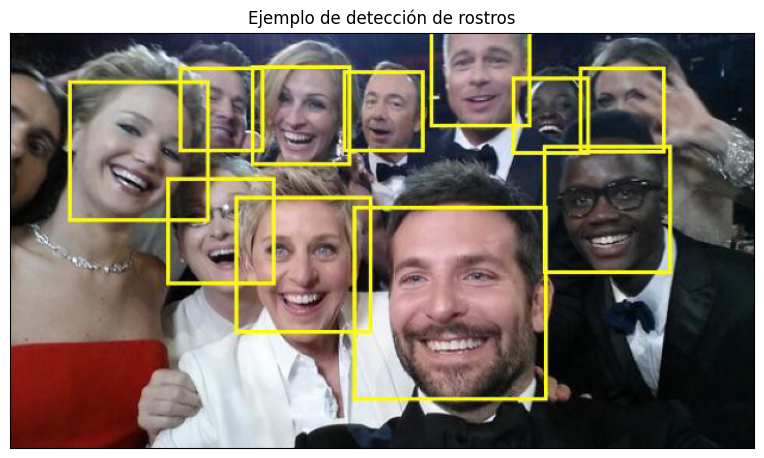

In [ ]:
# Leer la imagen a color
im1 = readIm(get_image('1.png'), flagColor=1)

# Mostrar la imagen
displayIm(rangeDisplay01(im1, flag_GLOBAL=True), title='Ejemplo de detección de rostros', factor=1.5)

Los diferentes archivos y resultados usados en este proyecto se encuentran en el siguiente enlace de Google Drive:

https://drive.google.com/drive/folders/1dB7OtOwB2__0FQpF2SjowMTJx9Cuxit0?usp=drive_link

# **2. Datasets**

## **2.1. COCO**

Hemos obtenido los pesos de YOLOv3 después de ser entrenada en el dataset
**COCO (Common Objects in COntext)**. COCO fue desarrollado por Microsoft en colaboración con académicos de varias universidades. Se lanzó por primera vez en 2014 y desde entonces ha sido una referencia estándar en la comunidad de Visión por Computador.

Este conjunto de datos contiene **más de 200,000 imágenes etiquetadas**, con **más de un millón de objetos etiquetados en 80 categorías diferentes** como **personas, animales, vehículos y objetos cotidianos**. Las imágenes son de la vida real y proporcionan una amplia gama de contextos y escenarios.

Para la tarea de reconocer caras no es necesaria toda la información de los distintos objetos reconocidos en COCO, pero si **aprovecharemos el reconocimiento de personas como base para nuestro detector de rostros**. Si bien es cierto, puede no llegar a ser una base muy buena debido a que en algunas imágenes de personas no aparecen sus caras o se encuentran en una perspectiva muy alejada.

A continuación añadimos el enlace al paper original con todo tipo de explicación de este dataset:

https://arxiv.org/pdf/1405.0312.pdf

## **2.2. WIDERFACE**

Vamos a usar el dataset WIDERFACE para
entrenar y evaluar los diferentes modelos. Este dataset es público (al igual que COCO) y está específicamente diseñado para la detección de rostros en imágenes. Proporciona un gran conjunto de imágenes con una amplia gama de condiciones y escenarios, lo que lo hace muy útil para entrenar y evaluar algoritmos de detección de rostros.

El conjunto de datos contiene **más de 32,000 imágenes en total y 393,703 caras etiquetadas y anotadas con cuadros delimitadores**, lo que facilita su uso en tareas de detección. Esto hace que sea uno de los conjuntos de datos más grandes y diversos para la detección de rostros. **Las imágenes incluyen una gran variedad de escenarios, desde rostros en primer plano hasta rostros en multitudes y bajo diversas condiciones de iluminación**.

Para la evaluación se proporcionan **16,151 imágenes (conjunto de test)** de distribución similar al de entrenamiento pero con imágenes nuevas para comprobar el buen funcionamiento de la red. Sin embargo, no se liberan los valores de *ground truth* para este conjunto y las competiciones asociadas y los servidores de evaluación están inactivos en este momento. Por ello, usaremos el **conjunto de validación** para evaluar los resultados, el cual contiene **3.230 imágenes**.

A continuación añadimos el enlace al paper original con todo tipo de explicación de este dataset:

https://arxiv.org/pdf/1511.06523.pdf

# **3. YOLOv3**

## **3.1. Descripción**

**YOLOv3 (You Only Look Once versión 3)** es una red neuronal con **arquitectura
completamente convolucional** dirigida a detección de objetos, que destacó en 2018 como uno de los algoritmos de detección más rápidos. Si bien es
cierto que había otros con mejor tasa de precisión, YOLO tiene como ventaja su
**bajo tiempo de ejecución** frente a los otros algoritmos, lo cual es esencial cuando necesitamos hacer **reconocimiento de objetos en tiempo real.**

Nos basaremos en el paper original para describir el funcionamiento de esta red:

https://arxiv.org/pdf/1804.02767.pdf

## **3.2. Funcionamiento general**

YOLOv3 realiza **detección en 3 escalas distintas**, de manera que devuelve un tensor3D para cada escala del mismo tamaño que la escala en la que está detectando, codificando la información de cada celda: las coordenadas de la caja, la puntuación de si es un objeto (querremos que sea 1 en el centro de la bounding box y 0 en caso contrario) y puntuación de cada clase. Además, en cada escala se predicen 3 cajas a partir de la desviación que tengan con otras de tamaño prefijado (*anchor boxes*). En cada escala se devuelve como predicción un tensor3D de tamaño $N×N×[3×(4+1+M)]$, con $N$ el tamaño de la escala y $M$ el número de clases a detectar (en nuestro caso $M = 1$ ya que solo tendremos la clase *face*).

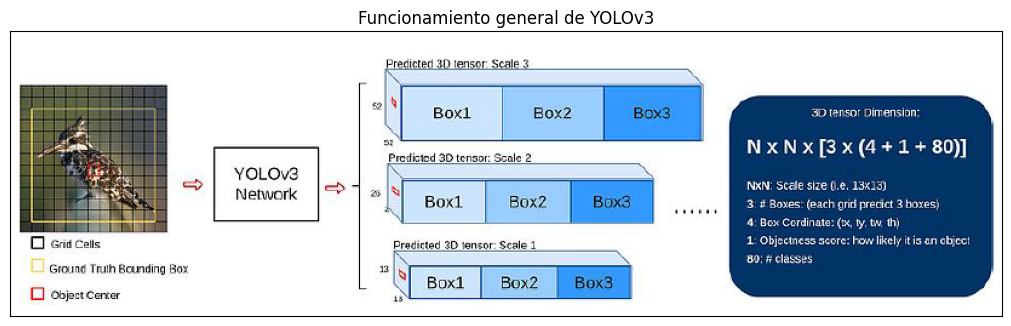

In [ ]:
# Leer la imagen a color
im2 = readIm(get_image('2.png'), flagColor=1)

# Mostrar la imagen
displayIm(rangeDisplay01(im2, flag_GLOBAL=True), title='Funcionamiento general de YOLOv3', factor=2)

## **3.3. Arquitectura**

Como ya hemos comentado, YOLOv3 usa una arquitectura completamente convolucional
(permitiendo que podamos pasar cualquier tamaño de imagen).

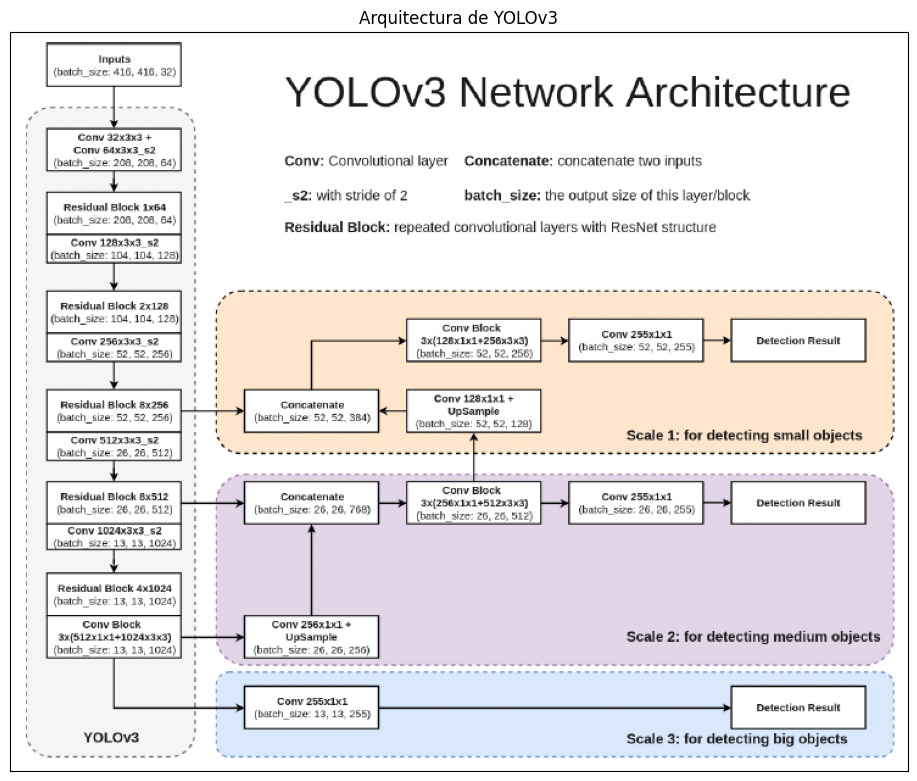

In [ ]:
# Leer la imagen a color
im3 = readIm(get_image('3.png'), flagColor=1)

# Mostrar la imagen
displayIm(rangeDisplay01(im3, flag_GLOBAL=True), title='Arquitectura de YOLOv3', factor=2)

Esta arquitectura se divide principalmente en dos partes:

1. **Darknet-53**: Es el **extractor de características a distintas escalas**, que se compone principalmente por 53 capas convolucionales, que incluye bloques
residuales (2 convoluciones + 1 skip), y con capas convolucionales con
stride 2 antes de cada bloque para hacer downsampling sin necesidad de
usar pooling. Además, después de cada convolucional se añade una capa
BatchNormalization y con activación Leaky ReLU.

    Vemos como se van incluyendo pequeños bloques con tamaño de filtros
pequeño, y aumentamos ambos valores conforme profundizamos la red. Al
final de cada bloque 8x se pasará una conexión a las escalas pequeña y
mediana.

2. **Detección en escalas**: Como los objetos a detectar pueden aparecer de
distintos tamaños y queremos detectarlos todos, tenemos un problema
puesto que la red conforme es más profunda más le cuesta detectar objetos
pequeños. YOLOv3 resuelve esto usando una **estructura de detección piramidal**
(*Feature Pyramid Network*) que se encarga de detectar en 3 escalas distintas
(pequeña, mediana y grande), resultantes de dividir las dimensiones de la
imagen de entrada entre 32, 16 y 8 respectivamente.

    El mapa de características que produce Darknet al final se pasa
a la escala grande directamente y a la mediana con upsampling 2x; en la
grande se pasa al detector, y en la mediana se concatena con otro mapa de
características (capa 61) menos profundo que se pasa a la escala mediana
con upsampling 2x y a la mediana directamente al detector. Finalmente
repetimos el proceso para la escala pequeña usando otro mapa de características
(capa 36) menos profundo todavía concatenado con lo anterior que
se pasa a un detector.

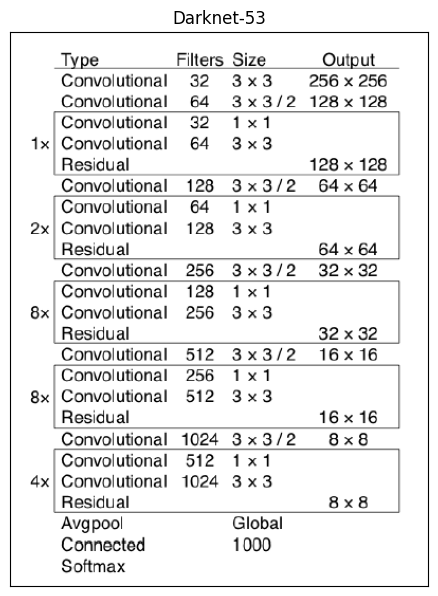

In [ ]:
# Leer la imagen a color
im4 = readIm(get_image('4.png'), flagColor=1)

# Mostrar la imagen
displayIm(rangeDisplay01(im4, flag_GLOBAL=True), title='Darknet-53', factor=1.5)

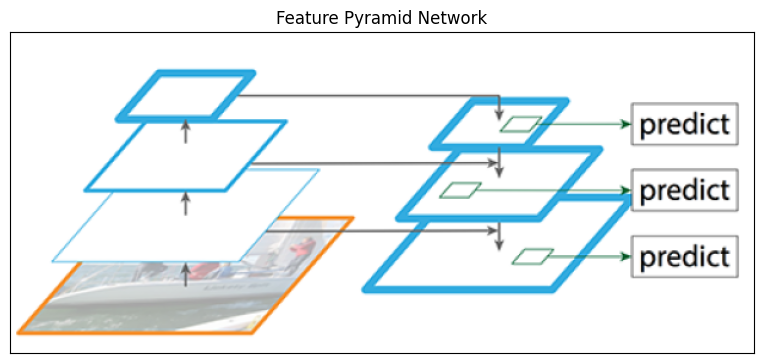

In [ ]:
# Leer la imagen a color
im5 = readIm(get_image('5.png'), flagColor=1)

# Mostrar la imagen
displayIm(rangeDisplay01(im5, flag_GLOBAL=True), title='Feature Pyramid Network', factor=1.5)

## **3.4. Predicción**

Imaginemos que tenemos una foto y queremos encontrar y clasificar objetos en ella, como un perros. YOLOv3 hace esto de una manera muy eficiente mediante los siguientes pasos:

1. **División de la Imagen**: Primero, YOLOv3 divide la imagen en una cuadrícula. Cada celda de esta cuadrícula será responsable de detectar objetos que estén en su área.

2. **Cajas Prefijadas (*Anchors*)**: En cada celda, YOLOv3 utiliza algo llamado "cajas prefijadas" (*anchors*). Podemos pensar en estas cajas como moldes de diferentes tamaños y proporciones que ayudan a identificar dónde podría estar un objeto en la celda. YOLOv3 generalmente usa **tres cajas prefijadas por celda, cada una de un tamaño diferente.**

3. **Predicciones por Caja**: Para cada caja prefijada, el algoritmo hace varias predicciones:

 - **Coordenadas de la caja**: Estas son las coordenadas que predicen dónde está el objeto dentro de la imagen. Básicamente, YOLOv3 ajusta el "molde" (caja prefijada) para envolver mejor al objeto detectado.

 - **Puntuación de objeto (*Objectness score*)**: Esto es una puntuación que indica qué tan seguro está el algoritmo de que hay un objeto en esa caja. Si es baja, probablemente no haya nada; si es alta, probablemente haya algo.

 - **Puntuación de clase**: Además de decirnos que hay un objeto, YOLOv3 intenta adivinar qué tipo de objeto es (por ejemplo, un perro). Da una puntuación para cada tipo de objeto que sabe identificar.

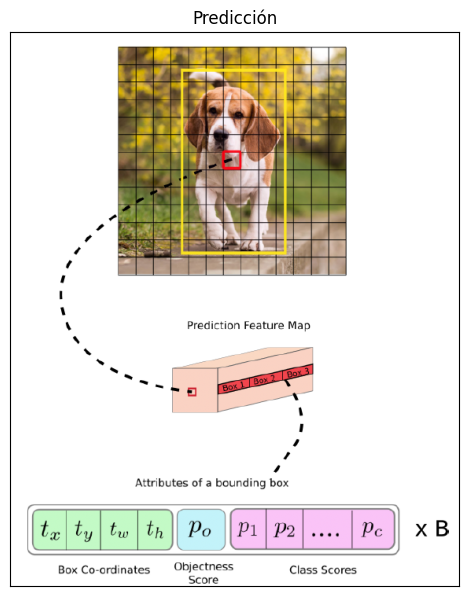

In [ ]:
# Leer la imagen a color
im6 = readIm(get_image('6.png'), flagColor=1)

# Mostrar la imagen
displayIm(rangeDisplay01(im6, flag_GLOBAL=True), title='Predicción', factor=1.5)

### **3.4.1. Coordenadas de la caja**

Se predicen 4 coordenadas para cada *bounding box*: **las coordenadas $x$ e $y$ del centro, la anchura de la caja y altura de la caja**. Denotémoslas $t_x, t_y, t_w$ y $t_h$, respectivamente.

Si la celda está desplazada de la esquina superior izquierda por un $(c_x, c_y)$, y siendo $p_w, p_h$
la anchura y altura de la caja prefijada, respectivamente, y $σ$ una función sigmoide, entonces las coordenadas predecidas de la caja son:

$$b_x = σ(t_x) + c_x$$
$$b_y = σ(t_y) + c_y$$
$$b_w = p_we^{t_w}$$
$$b_h = p_he^{t_h}$$

**Para calcular las coordenadas predecidas se usa como función de pérdida la suma de los errores cuadrados** (se intenta minimizar la diferencia entre las coordenadas de las cajas delimitadoras predichas por el modelo y las coordenadas reales de los objetos en las imágenes de entrenamiento, con el objetivo de mejorar la precisión del modelo en la predicción de estas coordenadas.)

Finalmente, **estas coordenadas predecidas se normalizan entre la dimensión de la celda del mapa de características**. Por tanto si las coordenadas del centro predichas son mayores que 1, producen que se salga del centro, de ahi que usemos la función sigmoide (deja el valor entre 0 y 1). A la altura y anchura les pasa igual, y son normalizadas por el cociente anchura/altura de la imagen.

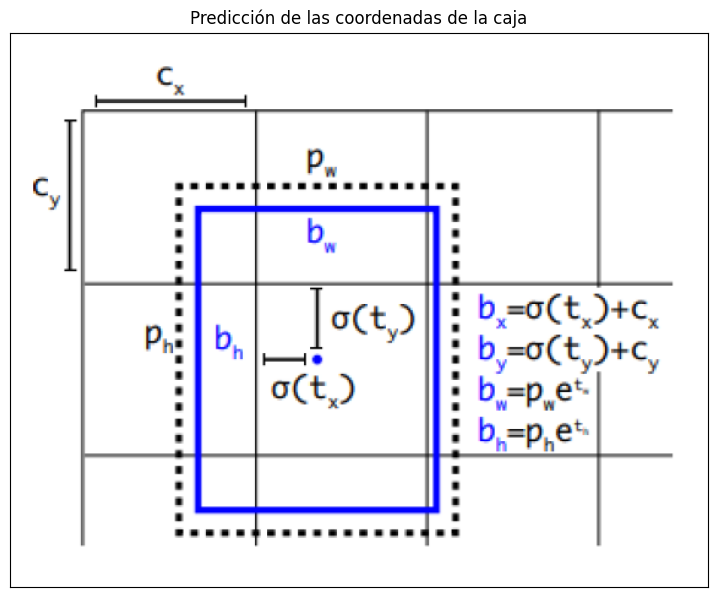

In [ ]:
# Leer la imagen a color
im7 = readIm(get_image('7.png'), flagColor=1)

# Mostrar la imagen
displayIm(rangeDisplay01(im7, flag_GLOBAL=True), title='Predicción de las coordenadas de la caja', factor=1.5)

### **3.4.2. Puntuación de objeto (*Objectness score*)**

Como ya hemos dicho antes, la puntuación de objeto consiste en cómo de probable es que un objeto esté dentro de la caja, por lo que idealmente queremos que esta puntuación sea **cercana a 1 dentro de la caja, mientras que por las las zonas exteriores cercanas a la caja sea casi 0.**

### **3.4.3. Puntuación de clase**

Cada caja predice la clase que puede tener el bounding box mediante **clasificación logística multietiqueta**. No se usa softmax puesto que no influye en términos de rendimiento, y además, de esta manera, se permiten clases solapadas.

## **3.5. Detección**

Cuando hacemos detección obtendremos muchas cajas, por lo que tendremos que
filtrarlas. Primero ordenamos las cajas según su puntuación de objeto, ignoramos
las que no sobrepasen un cierto umbral y finalmente aplicamos **supresión de
no-máximos** para condensar muchas cajas que estén superpuestas.

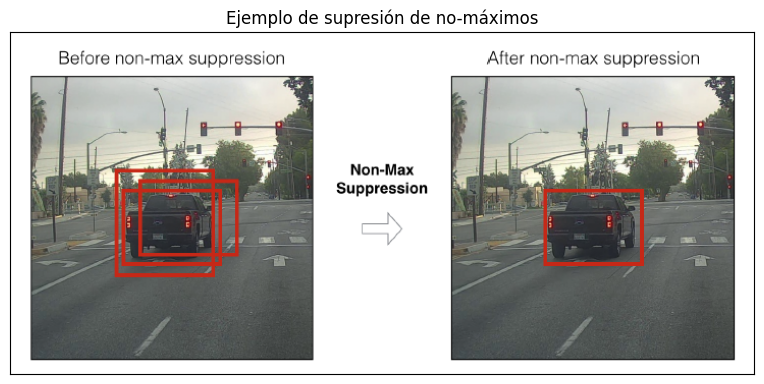

In [ ]:
# Leer la imagen a color
im8 = readIm(get_image('8.png'), flagColor=1)

# Mostrar la imagen
displayIm(rangeDisplay01(im8, flag_GLOBAL=True), title='Ejemplo de supresión de no-máximos', factor=1.5)

# **4. Métricas**

Para evaluar los modelos usaremos la métrica **mAP (mean Average Precision)**.
Para está metrica primero definimos las medidas de **precision** y **recall**:

- **Precision**: Mide el porcentaje de predicciones correctas, lo que implica evaluar si las cajas delimitadoras predichas por el modelo realmente contienen un objeto de la clase específica que se está prediciendo.

$$\text{Precision} = \frac{\text{Verdaderos positivos}}{\text{Verdaderos positivos + Falsos positivos}}$$

- **Recall**: Mide el pocentaje de casos positivos encontrados, es decir, la
proporción de objetos detectados frente al total de objetos a detectar.

$$\text{Recall} = \frac{\text{Verdaderos positivos}}{\text{Verdaderos positivos + Verdaderos negativos}}$$

Para evaluar si un caja predicha es correcta, tomaremos la predicción y el *ground truth* y calculamos su **IoU (Intersection over Union)**, que consiste en calcular la proporción del área donde las dos cajas se intersecan frente al área de las dos cajas unidas. Diremos que la predicción es correcta si el valor IoU vale más que un cierto umbral prefijado.

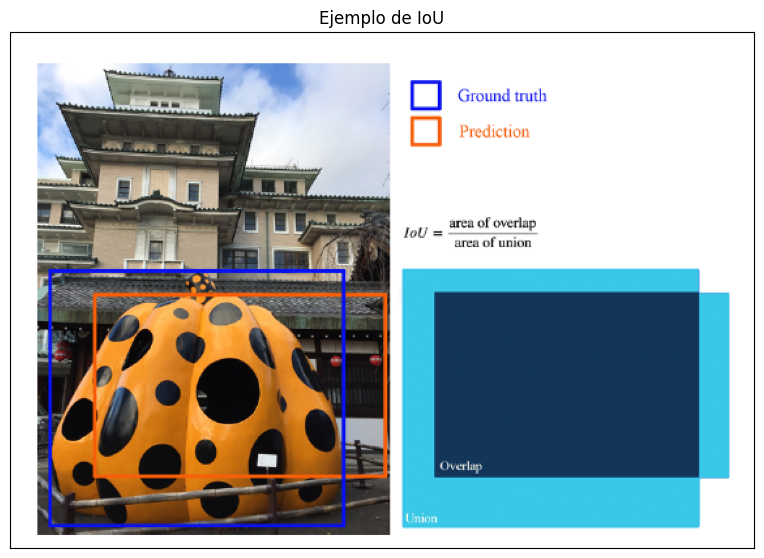

In [ ]:
# Leer la imagen a color
im9 = readIm(get_image('9.png'), flagColor=1)

# Mostrar la imagen
displayIm(rangeDisplay01(im9, flag_GLOBAL=True), title='Ejemplo de IoU', factor=1.5)

Ahora representamos la **curva $p(r)$ (*precision-recall* o *PR*)** de la siguiente manera: ordenamos las detecciones por la probabilidad de la clase, miramos si ha sido un verdadero positivo (acierto) o un falso positivo (detecta algo incorrecto), y procedemos a calcular la *precision* y el *recall* actual, obteniendo un punto de la curva.

En la imagen siguiente vemos un ejemplo de 10 detecciones.

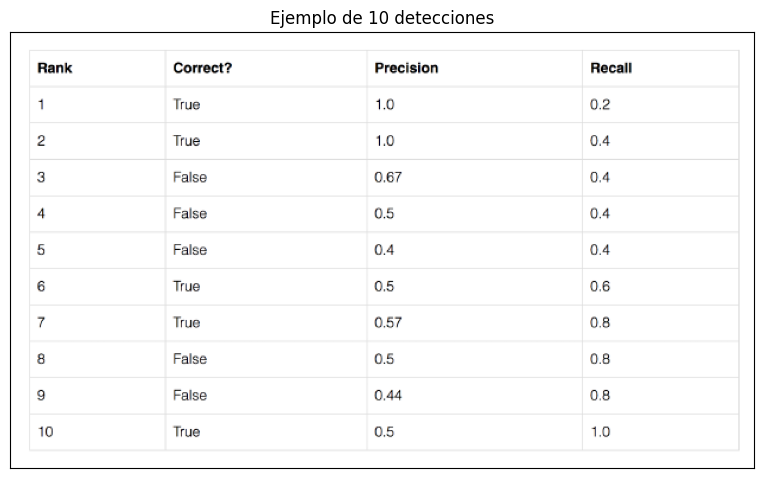

In [ ]:
# Leer la imagen a color
im10 = readIm(get_image('10.png'), flagColor=1)

# Mostrar la imagen
displayIm(rangeDisplay01(im10, flag_GLOBAL=True), title='Ejemplo de 10 detecciones', factor=1.5)

Como vemos el *recall* va en aumento, ya que puede quedarse igual o crecer (o
no detectamos o detectamos más), mientras que la precisión va fluctuando según
acertemos con las detecciones.

Veamos ahora en la siguiente imagen la curva PR que tendríamos para este ejemplo.

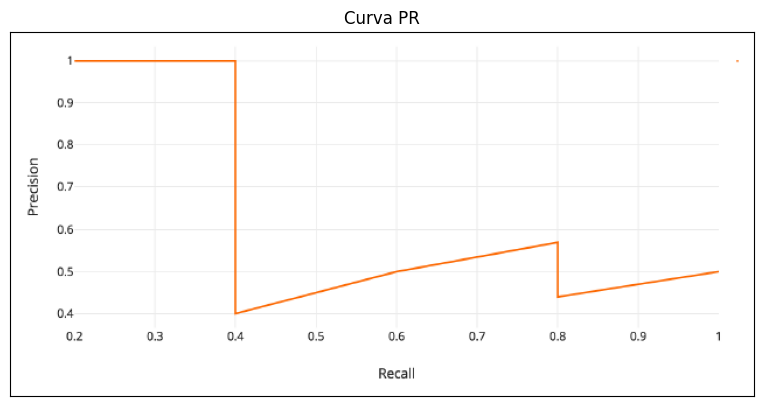

In [ ]:
# Leer la imagen a color
im11 = readIm(get_image('11.png'), flagColor=1)

# Mostrar la imagen
displayIm(rangeDisplay01(im11, flag_GLOBAL=True), title='Curva PR', factor=1.5)

Entonces, definimos en este caso **AP (Average Precision)** como el área debajo de la curva PR, es decir:

$$AP = \int_{0}^{1}{p(r)dr},$$

de forma que toma valores en el intervalo $[0,1]$.

Sin embargo, para calcular la integral se toma la curva suavizando el "zigzag" que presenta, para evitar el impacto de las pequeñas variaciones. Así, cambiamos el valor de la precisión de cada punto por la mayor precision que haya a la derecha del punto (es decir, la mayor precision alcanzada para un *recall* mayor o igual que el actual):

$$p_{inter}(r) = \max_{r' \geq r} p(r')$$

En nuestro ejemplo anterior quedaría algo así:

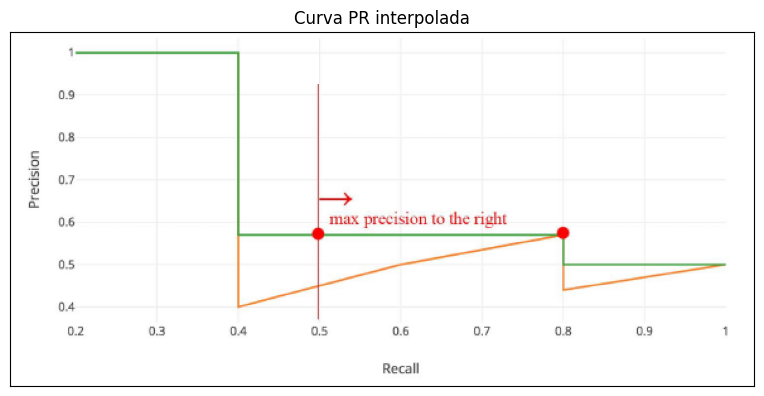

In [ ]:
# Leer la imagen a color
im12 = readIm(get_image('12.png'), flagColor=1)

# Mostrar la imagen
displayIm(rangeDisplay01(im12, flag_GLOBAL=True), title='Curva PR interpolada', factor=1.5)

Ahora tomamos una aproximación usando 11 valores de *recall* equiespaciados
(también puede hacerse con 101) dados por $(0, 0.1, ..., 1)$ y haciendo la media de la precisión en estos valores:

$$AP = \frac{1}{11} \sum_{r_i \in \{0,0.1,...,1\}} p_{\text{inter}}(r_i)$$

El **mAP es el promedio de los valores de AP para todas las clases de objetos que el modelo está tratando de detectar**. Por ejemplo, si el modelo detecta perros, gatos y autos, se calcularía el AP para cada uno de ellos y luego se tomaría el promedio de esos tres AP para obtener el mAP. **En nuestro caso, solo tenemos una clase (la clase *face*) por lo que el mAP coincide con el AP.**

En nuestro caso utilizaremos dos medidas, que son las más usuales en problemas
de detección actualmente: $mAP@0.5$ y $mAP@[.5:.95]$.

- $mAP@0.5$: Esta métrica calcula el mAP con un umbral de IoU de 0.5.

- $mAP@[.5:.95]$: Esta métrica calcula la media de los mAP para varios umbrales de IoU, desde 0.5 hasta 0.95, en pasos de 0.05.

En el siguiente enlace se encuentra una explicación muy detallada acerca de estas métricas:

https://www.v7labs.com/blog/mean-average-precision

# **Marco Práctico**

Como ya hemos comentado, utilizaremos la red YOLOv3 para realizar detección
de caras en imágenes. En particular, utilizaremos la siguiente implementación en Keras:

https://github.com/experiencor/keras-yolo3

**Esta implementación estaba hecha para Tensorflow 1 y hemos tenido que adaptarla a Tensorflow 2**.

También nuestro drive y establecemos el directorio de trabajo. Debemos tener los siguientes archivos disponibles en el mismo:

- Una carpeta `yolov3` con los ficheros de código disponibles en el repositorio, respetando la estructura presente en el mismo.

- Una carpeta llamada `widerface` que contiene a su vez 4 subcarpetas:
  - `train`: Contiene las imágenes de entrenamiento.
  - `train_annot`: Contiene las anotaciones de las imágenes de entrenamiento en formato VOC.
  - `valid`: Contiene las imágenes de validación.
  - `valid_annot`: contiene las anotaciones de las imágenes de validación en formato VOC.

- Diferentes archivos de configuración que definan los entornos para los diferentes modelos: `config_base.json`, `config_model1_416.json`, `config_model1_1024.json`, etc.

- Una carpeta `models` donde se guardarán los modelos entrenados. Debe contener inicialmente un archivo backend.h5 con pesos preentrenados de la red concreta que se ha implementado (YOLOv3 en nuestro caso) en el dataset COCO.

https://drive.google.com/drive/u/1/folders/1dB7OtOwB2__0FQpF2SjowMTJx9Cuxit0

Durante el entrenamiento se crearán automáticamente archivos auxiliares en el directorio de trabajo.

**Las anotaciones en formato VOC pueden obtenerse a partir de las originales empleando el script `yolov3/utils/convert_annot.py`.**

# **1. Consideraciones previas al uso de la red**

Para tener un entorno de desarrollo adecuado se necesita hacer los siguiente:

- Es necesario generar las *anchor boxes* para nuestro dataset.
Ya dijimos que la red YOLOv3 predice *offsets* respecto a estos valores
predeterminados, por lo que si queremos entrenar la red con imágenes
de nuestro nuevo conjunto debemos proporcionar estas cajas prefijadas.
Para ello, utilizamos el fichero `gen_anchors.py` que simplemente aplica
el algoritmo de k-medias en el conjunto de entrenamiento para predecir
3 *anchor boxes* en cada escala, dadas en función del alto y del ancho. El
resultado es el siguiente:

$$[[2, 4, 4, 8, 7, 14], [12, 23, 20, 36, 35, 56], [56, 95, 101, 149, 177, 234]]$$

- Para trabajar con las anotaciones de *ground truth* es necesario convertirlas
al formato VOC que maneja la implementación proporcionada. Para ello
utilizamos el script `utils/convert_annot.py`, adaptado del siguiente código:

  https://github.com/akofman/wider-face-pascal-voc-annotations/blob/master/convert.py

- Hay que descargar los pesos preentrenados de la red en el dataset COCO. Estos pesos se corresponden a todas las capas convolucionales, sin contar las capas de detección que dependen del dataset concreto que utilicemos. El archivo `backend.h5` del siguiente enlace contiene dichos pesos preentrenados de la red en el dataset COCO es el siguiente:

  https://drive.google.com/drive/u/1/folders/1xozeEGh4wnc99ZcW9LxcHivDK4oUYi5Q

- Disponemos de varios archivos de configuración para los diferentes modelos: `config_base.json`, `config_model1_416.json`, `config_model1_1024.json`, etc.  Estos archivos ayudan a establecer la ruta de las imágenes y de las anotaciones, y establecemos el nombre de las clases que queremos detectar. En nuestro caso será una única clase llamada *face*. Además, tenemos este cuaderno en Google Colab para las ejecuciones. Este cuaderno puede consultarse en el archivo `proyectoVC.ipynb`. Los detalles sobre el código que contiene, así como del resto de archivos que se utilizan en la implementación de YOLOv3 en Keras, se pueden consultar en el siguiente apartado (Funcionamiento del código).


# **2. Funcionamiento del código**

En el enlace de Google Drive de este proyecto podemos encontrar la carpeta `yolov3` con los diferentes archivos de código .py.

https://drive.google.com/drive/u/1/folders/1b3XgC15ImAxbua-_Fv6pLiLsChyJ4j0S

## **2.1. Funcionamiento del código**

En el archivo `yolo.py` se encuentra la función `create_yolov3_model()` para crear un modelo completo, utilizando la función auxiliar `_conv_block()` para ir creando los bloques convolucionales. Hemos realizado algunas modificaciones que nos permitan congelar las capas del extractor de características si queremos.

Además, en el archivo `voc.py` se encuentra la función `parse_voc_annotation()`
que nos permite leer las anotaciones de un fichero y crear las variables necesarias para describir adecuadamente cada imagen.

## **2.2. Generadores de imágenes**

En el archivo `generator.py` se encuentran funciones para manejar un generador
personalizado de imágenes. Es aquí donde se realiza el aumento de datos (data augmentation) y se controla cómo se van generando imágenes en cada paso por la red.

## **2.3. Entrenamiento**

El archivo `train.py` junto con la función `_train()` que se encuentra en este notebook controlan el entrenamiento del modelo. Se comienza leyendo las anotaciones para obtener el conjunto de imágenes de entrenamiento anotadas. Después se crea un generador de imágenes con los parámetros adecuados, y a continuación se general el modelo con `create_model()`. Esta función se encarga de cargar los pesos preentrenados si existen y de compilar el modelo. Después se añaden los callbacks deseados mediante `create_callbacks()` y finalmente usamos `fit()` para comenzar el entrenamiento.

## **2.4. Evaluación**

Para obtener la métrica $mAP@[.5:.95]$ se dispone de la función `evaluate_coco()` y, de igual forma, para la métrica $mAP@0.5$ se tiene la función `evaluate_pascal()`. Ambas funciones se encuentran en el archivo `evaluate.py` Para evaluar el modelo mediante el conjunto de validación y calcular dichas métricas anteriores, hemos implementado la función `_evaluate()` en este cuaderno.

## **2.5. Detección**

Se proporcionan las funciones `_detect_one()` y `_detect_video()` en este cuaderno para realizar detecciones en imágenes y vídeos. La primera recibe como parámetro o bien la anotación de una imagen o bien la ruta de la misma. Después de leer correctamente la imagen y las anotaciones (si las hubiera), llama a la función `get_yolo_boxes()`. Esta se encarga de realizar la predicción completa de cajas en la imagen: pasa la imagen por la red, decodifica el resultado mediante `decode_netout()`, corrige las cajas para que se puedan representar en las dimensiones de la imagen de entrada con `correct_yolo_boxes()`, y realiza supresión de no-máximos con `do_nms()`. Todas estas funciones se encuentran en los diferentes archivos .py de la carpeta `yolov3/utils` del Google Drive.

Una vez detectadas las cajas, las dibujamos sobre las imágenes con la función
`draw_boxes()`.

El procedimiento para detección en vídeo sigue la misma idea, pero se sirve de
las clases `VideoCapture` y `VideoWriter` de *OpenCV* para extraer los frames del vídeo y poder realizar detecciones en ellos.

Se proporciona también el archivo `detect.py` para realizar detecciones en local
sin tener que usar este cuaderno.

# **3. Aspectos de entrenamiento de la red**

Estudiamos a continuación las consideraciones más relevantes que hemos hecho a
la hora de ajustar la red a nuestro conjunto de datos. Hemos decidido entrenar
la red, pues al querer detectar una clase con la que no había sido entrenada
anteriormente (en COCO no existe la clase *face*) pensamos que necesitaría ser
entrenada de forma profunda en el nuevo conjunto.

Enumeramos los **principales parámetros y técnicas** que contemplamos.

## **3.1. Data augmentation**

La primera mejora que consideramos es realizar aumento de imágenes para obtener
una mayor precisión en el conjunto de validación. Mediante la configuración de los parámetros `min_input_size` y `max_input_size` de los archivos de configuración podemos establecer los tamaños mínimo y máximo de las imágenes, que deberán ser siempre múltiplos de 32. Por limitaciones en el entorno utilizado **rara vez podremos superar tamaños de 512 × 512 para entrenar**.

A la hora de entrenar, las imágenes se redimensionan automáticamente cada
10 batches a algún tamaño comprendido entre el mínimo y el máximo que sea
múltiplo de 32.

También aplicamos transformaciones aleatorias de escala y recorte, cuya intensidad se controla mediante el parámetro `jitter` para el generador de imágenes de entrenamiento. Por defecto la fijamos a 0.3.

## **3.2. Tamaño del batch**

Debido a las limitaciones en cuanto a la memoria disponible, nos vemos obligados
a utilizar un **batch size de 4** para las imágenes de entrenamiento en todo momento.

## **3.3. Optimizador y learning rate**

Empleamos el **optimizador Adam** para compilar cada modelo. Comenzamos a entrenar
los modelos con un **learning rate de 0.001**, que es el valor por defecto
de este optimizador. Disponemos de un callback de `ReduceLROnPlateau`, que
establece un learning rate 10 veces menor cada vez que llevemos dos épocas sin
mejorar la función de pérdida. De esta forma conseguimos acelerar la convergencia en las épocas iniciales y ajustar gradualmente los pesos conforme avanzamos en el entrenamiento.

## **3.4. Épocas de "calentamiento"**

El parámetro `warmup_epochs` de los archivos de configuración permite especificar un número de épocas iniciales en las cuales las cajas predichas por el modelo deben coincidir en tamaño con los *anchors* especificados. Lo fijamos a 3, y notamos que solo se aplica en las primeras épocas del entrenamiento.

## **3.5. Umbral de predicción**

Internamente la red utiliza el parámetro `ignore_thresh` de los archivos de configuración para decidir qué hacer con una predicción. Si el solapamiento entre la caja predicha y el valor de *ground truth* es mayor que dicho umbral, dicha predicción no contribuye al error. En otro caso, sí contribuye.

Si este umbral es demasiado alto, casi todas las predicciones participarán en el
cálculo del error, lo que puede causar overfitting. Por el contrario, si este valor es demasiado bajo perderemos demasiadas contribuciones al error y podríamos causar underfitting. El valor por defecto es 0.5.

## **3.6. Cálculo de la función de error**

Mediante los parámetros `obj_scale`, `noobj_scale`, `xywh_scale` y `class_scale` de los archivos de configuración podemos fijar la escala en la que afecta cada parte al error total. El primero se refiere al error dado al predecir que algo es un objeto cuando en realidad no lo era, y el segundo a la acción contraria. El tercero controla el error en la predicción de las cajas frente a los valores reales, y el cuarto el error en la predicción de clase. Los valores por defecto son 5, 1, 1 y 1, respectivamente.

## **3.7. Otros callbacks**

Disponemos de un callback de `ModelCheckpoint` que va guardando un modelo con
los mejores pesos obtenidos hasta el momento, de forma que podemos reanudar
el entrenamiento por donde nos quedásemos. También tenemos un callback de
`EarlyStopping` para detener el entrenamiento si no disminuye el error en 7
épocas.

# **4. Modelos entrenados y evaluación**

Los parámetros utilizados para todas las evaluaciones son `obj_thresh = 0.5` y
`nms_thresh = 0.4`. El primer parámetro se refiere al umbral a partir del cual se considera que un objeto detectado es realmente un objeto (el resto se descartan), y el segundo controla el umbral de la supresión de no-máximos realizada para eliminar detecciones solapadas.

Mostramos ahora los modelos finales que hemos obtenido. Hemos hecho más
pruebas de las que se reflejan aquí, pero la mayoría han sido ineficaces. En el directorio `logs` de Google Drive se guardan los historiales de entrenamiento para consultar gráficas con la herramienta Tensorboard.

En el siguiente enlace a Google Drive se pueden descargar los modelos que hemos entrenado:

https://drive.google.com/drive/u/1/folders/1xozeEGh4wnc99ZcW9LxcHivDK4oUYi5Q

## **4.1. Funciones previas**

In [ ]:
# Instalamos Tensorflow en su última versión (por si no estuviera instalado)
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


En los archivos de configuración, los **parámetros de entrenamiento más destacables** son:

- `min_input_size` y `max_input_size`: Controlan el rango en el que serán redimensionadas las imágenes de entrenamiento. Deben ser múltiplos de 32.

- `input_size`: Controla el tamaño de entrada de las imágenes de validación. Debe ser múltiplo de 32.

- `batch_size` y `learning_rate`: Tamaño de cada batch y learning rate inicial del optimizador Adam.

- `nb_epochs` y `warmup_epochs`: Establecen el número de épocas de entrenamiento normales y el número de épocas de entrenamiento iniciales en las que se fuerza a que las *bounding boxes* coincidan con los *anchors*. En total, el modelo se entrenará durante un número de épocas igual a la suma de estos parámetros.

- `saved_weights_name`: Indica la ruta en la que se guardará el modelo entrenado en formato HDF5.

Como ya comentamos, disponemos opcionalmente de un *callback* de Early Stopping que detiene el entrenamiento si la función de pérdida no mejora en 7 épocas. También tenemos otro *callback* (activado por defecto) que reduce el learning rate en un orden de magnitud 10 si la pérdida no mejora en 2 épocas.

El archivo con el modelo entrenado puede usarse para renaudar el entrenamiento (se carga con la función `load_weights()` como se puede observar en el archivo `train.py`) o para realizar predicciones (se carga con la función `load_model()`).

In [ ]:
# Función para el entrenamiento de los modelos

def _train(epochs, fine_tune = 0, early_stop = False):
  ###############################
  #   Leemos anotaciones
  ###############################
  train_ints, _, labels, max_box_per_image = create_training_instances(
      config['train']['train_annot_folder'],
      config['train']['train_image_folder'],
      config['train']['cache_name'],
      config['valid']['valid_annot_folder'],
      config['valid']['valid_image_folder'],
      config['valid']['cache_name'],
      config['model']['labels']
  )
  print('\nTraining on: \t' + str(labels) + '\n')

  ##################################
  #   Creamos generador de imágenes
  ##################################
  train_generator = BatchGenerator(
      instances           = train_ints,
      anchors             = config['model']['anchors'],
      labels              = labels,
      downsample          = 32,
      max_box_per_image   = max_box_per_image,
      batch_size          = config['train']['batch_size'],
      min_net_size        = config['model']['min_input_size'],
      max_net_size        = config['model']['max_input_size'],
      shuffle             = True,
      jitter              = 0.3,
      norm                = normalize
  )

  ###############################
  #   Creamos el modelo
  ###############################
  if os.path.exists(config['train']['saved_weights_name']):
    config['train']['warmup_epochs'] = 0
  warmup_batches = config['train']['warmup_epochs'] * (config['train']['train_times']*len(train_generator))

  os.environ['CUDA_VISIBLE_DEVICES'] = config['train']['gpus']
  multi_gpu = len(config['train']['gpus'].split(','))

  train_model, infer_model = create_model(
      nb_class            = len(labels),
      anchors             = config['model']['anchors'],
      max_box_per_image   = max_box_per_image,
      max_grid            = [config['model']['max_input_size'], config['model']['max_input_size']],
      batch_size          = config['train']['batch_size'],
      warmup_batches      = warmup_batches,
      ignore_thresh       = config['train']['ignore_thresh'],
      multi_gpu           = multi_gpu,
      saved_weights_name  = config['train']['saved_weights_name'],
      lr                  = config['train']['learning_rate'],
      grid_scales         = config['train']['grid_scales'],
      obj_scale           = config['train']['obj_scale'],
      noobj_scale         = config['train']['noobj_scale'],
      xywh_scale          = config['train']['xywh_scale'],
      class_scale         = config['train']['class_scale'],
      backend_path        = DIR + "models/backend.h5",
      fine_tune           = fine_tune
  )

  ################################
  #   Comenzamos el entrenamiento
  ################################
  callbacks = create_callbacks(config['train']['saved_weights_name'], config['train']['tensorboard_dir'], infer_model)

  if not early_stop:
    callbacks = callbacks[1:]

  hist = train_model.fit(
      train_generator,
      steps_per_epoch  = len(train_generator) * config['train']['train_times'],
      epochs           = epochs + config['train']['warmup_epochs'],
      verbose          = 2 if config['train']['debug'] else 1,
      callbacks        = callbacks,
      workers          = 4,
      max_queue_size   = 8
  )

  model_loaded = False
  print("\nEntrenamiento completado.")

Para obtener la métrica $mAP@[.5:.95]$ se dispone de la función `evaluate_coco()` y, de igual forma, para la métrica $mAP@0.5$ se tiene la función `evaluate_pascal()`. Para evaluar el modelo mediante el conjunto de validación y calcular dichas métricas anteriores, hemos implementado la función `_evaluate()`.

In [ ]:
# Función para la evaluación de los modelos

def _evaluate(model, calculate_ap = False):
  # Leemos las anotaciones
  valid_ints, labels = parse_voc_annotation(
      config['valid']['valid_annot_folder'],
      config['valid']['valid_image_folder'],
      config['valid']['cache_name'],
      config['model']['labels']
  )

  labels = labels.keys() if len(config['model']['labels']) == 0 else config['model']['labels']
  labels = sorted(labels)

  # Creamos el generador de imágenes de validación
  valid_generator = BatchGenerator(
      instances           = valid_ints,
      anchors             = config['model']['anchors'],
      labels              = labels,
      downsample          = 32,
      max_box_per_image   = 0,
      batch_size          = config['train']['batch_size'],
      min_net_size        = config['model']['min_input_size'],
      max_net_size        = config['model']['max_input_size'],
      shuffle             = True,
      jitter              = 0.0,
      norm                = normalize
  )

  # Realizamos predicciones y guardamos resultados en fichero
  detections, annotations = predict_boxes(
      model,
      valid_generator,
      obj_thresh = 0.5,
      nms_thresh = 0.45,
      net_h=config['model']['input_size'],
      net_w=config['model']['input_size'],
      save_path = config['valid']['valid_result'])

  if calculate_ap:
    # Calculamos las métricas de evaluación
    map_coco = evaluate_coco(
        model,
        valid_generator,
        detections,
        annotations,
        iou_start = 0.5,
        iou_step = 0.05,
        num_iou = 10)

    map_pascal = evaluate_pascal(
        model,
        valid_generator,
        detections,
        annotations)

    # Imprimimos los resultados
    print('mAP@[.5:.95]: {:.4f}'.format(map_coco[0]))
    print('mAP@0.5: {:.4f}'.format(map_pascal[0]))

Definimos **funciones para utilizar nuestro modelo como detector de caras tanto en imágenes como en vídeos**.

En el primer caso se muestra la imagen con las caras detectadas, y opcionalmente se muestra la posición real de las caras según las anotaciones de *ground truth*. Recibe como entrada un archivo que puede ser una anotación (si se quiere mostrar el valor real de las bounding boxes anotadas) o la ruta de una imagen.

En el segundo caso, partiendo de un vídeo de entrada se construye un nuevo vídeo donde aparecen las *bounding boxes* detectadas en cada frame, de forma continua.

In [ ]:
# Función para la detección de rostros en una imagen

def _detect_one(
  model,
  filein,
  img_dir,
  is_annot = False,
  show = True,
  show_ground_truth = False):
  if is_annot:
    # Analizamos la anotación
    im_inst = parse_single_annot(filein, img_dir)
    filename = im_inst['filename']
  else:
    filename = filein

  # Leemos la imagen
  im = readIm(filename)

  # Ground truth
  if show_ground_truth:
    ground_boxes = [BoundBox(obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'])
                    for obj in im_inst['object']]

  # Predecimos las bounding boxes
  pred_boxes = get_yolo_boxes(
      model,
      images = [im],
      net_h = config['model']['input_size'],
      net_w = config['model']['input_size'],
      anchors = config['model']['anchors'],
      obj_thresh = 0.5,
      nms_thresh = 0.45)[0]

  # Dibujamos las bounding boxes
  im_boxes = draw_boxes(im, pred_boxes, color = (0, 255, 25))

  if show_ground_truth:
    im_boxes = draw_boxes(im, ground_boxes, show_score = False, color = (255, 0, 25))

  # Mostramos la imagen
  if show:
    displayIm(im_boxes)

  return im_boxes

# Función para la detección de rostros en un vídeo

def _detect_video(model, filein, fileout):
  # Abrimos el vídeo
  video_reader = cv2.VideoCapture(filein)

  # Recolectamos información del vídeo
  frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  fps = video_reader.get(cv2.CAP_PROP_FPS)

  # Creamos vídeo de salida
  video_writer = cv2.VideoWriter(
      fileout,
      cv2.VideoWriter_fourcc(*'MPEG'),
      fps,
      (frame_w, frame_h))

  batch_size  = 1
  images      = []
  for i in tqdm(range(frames)):
    # Leemos frames del vídeo
    _, image = video_reader.read()
    images += [image]

    if (i%batch_size == 0) or (i == (frames-1) and len(images) > 0):
      # Predecimos bounding boxes
      batch_boxes = get_yolo_boxes(
          model,
          images,
          config['model']['input_size'],
          config['model']['input_size'],
          config['model']['anchors'],
          obj_thresh = 0.6,
          nms_thresh = 0.4)

      for i in range(len(images)):
        # Dibujamos bounding boxes
        draw_boxes(images[i], batch_boxes[i], show_score = False)

        # Escribimos imágenes en el vídeo de salida
        video_writer.write(images[i])

    images = []

  # Liberamos recursos
  video_reader.release()
  video_writer.release()

## **4.2. Modelo Base**

En primer lugar generamos un modelo base con el que compararemos nuestros
intentos de mejora. Se trata simplemente de un **modelo con los pesos preentrenados de COCO y una capa de detección añadida en cada escala**. Utilizamos los parámetros por defecto (se pueden ver en el archivo de configuración `config_base.json`), realizamos data augmentation, y elegimos un tamaño de entrada de 416 × 416. Lo entrenamos durante 10 épocas (más las 3 épocas de "calentamiento"), congelando todas las capas excepto las 3 añadidas. Cada época ha tardado unos 360 segundos (6 minutos) aproximadamente (excepto la primera época de "calentamiento", la cual siempre tarda más, tardando en este caso 2400 segundos aproximadamente, es decir, 40 minutos). El loss fue disminuyendo hasta estancarse en aproximadamente 13.1.

In [ ]:
# Archivo de configuración
config_path = DIR + "config_base.json"
with open(config_path) as config_buffer:
  config = json.loads(config_buffer.read())

In [ ]:
# Definimos los parámetros de entrenamiento
EARLY_STOP = True
FINE_TUNE = 1
EPOCHS = config['train']['nb_epochs']

# Entrenamos el modelo
_train(EPOCHS, FINE_TUNE, EARLY_STOP)

Seen labels: 	{'face': 25485}

Given labels: 	['face']

Training on: 	['face']



/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/13

Epoch 1: loss improved from inf to 1392.97571, saving model to /content/drive/My Drive/proyectovc/models/base_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  1/518 [..............................] - ETA: 2:22:57 - loss: 1392.9757 - yolo_layer_loss: 152.1275 - yolo_layer_1_loss: 356.0276 - yolo_layer_2_loss: 884.8206
Epoch 1: loss did not improve from 1392.97571
  2/518 [..............................] - ETA: 4:30 - loss: 1486.3245 - yolo_layer_loss: 217.0894 - yolo_layer_1_loss: 442.8879 - yolo_layer_2_loss: 826.3472   
Epoch 1: loss improved from 1392.97571 to 1292.23499, saving model to /content/drive/My Drive/proyectovc/models/base_model.h5
  3/518 [..............................] - ETA: 41:28 - loss: 1292.2350 - yolo_layer_loss: 195.2175 - yolo_layer_1_loss: 389.1446 - yolo_layer_2_loss: 707.8729
Epoch 1: loss improved from 1292.23499 to 1166.73853, saving model to /content/drive/My Drive/proyectovc/models/base_model.h5
  4/518 [..............................] - ETA: 39:28 - loss: 1166.7385 - yolo_layer_loss: 178.3142 - yolo_layer_1_loss: 368.6439 - yolo_layer_2_loss: 619.7804
Epoch 1: loss improved from 1166.73853 to 1067.25867, savi

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 9: loss did not improve from 17.72674
102/518 [====>.........................] - ETA: 4:26 - loss: 29.7055 - yolo_layer_loss: 4.9051 - yolo_layer_1_loss: 9.5730 - yolo_layer_2_loss: 15.2274
Epoch 9: loss did not improve from 17.72674
103/518 [====>.........................] - ETA: 4:25 - loss: 29.8076 - yolo_layer_loss: 4.9234 - yolo_layer_1_loss: 9.6025 - yolo_layer_2_loss: 15.2817
Epoch 9: loss did not improve from 17.72674
104/518 [=====>........................] - ETA: 4:24 - loss: 29.7225 - yolo_layer_loss: 4.9443 - yolo_layer_1_loss: 9.5895 - yolo_layer_2_loss: 15.1888
Epoch 9: loss did not improve from 17.72674
105/518 [=====>........................] - ETA: 4:23 - loss: 29.7125 - yolo_layer_loss: 4.9281 - yolo_layer_1_loss: 9.6113 - yolo_layer_2_loss: 15.1732
Epoch 9: loss did not improve from 17.72674
106/518 [=====>........................] - ETA: 4:22 - loss: 29.7392 - yolo_layer_loss: 4.9153 - yolo_layer_1_l

In [ ]:
# Cargamos el modelo
if not model_loaded:
  base_model = load_model(config['valid']['valid_model'])
  print("Loaded model: " + config['valid']['valid_model'])
  model_loaded = True

# Evaluamos el modelo
_evaluate(base_model, True)

mAP@[.5:.95]: 0.0246
mAP@0.5: 0.0827


Al evaluar este modelo obtenemos, como se esperaba, unos **resultados pésimos**. Esto es normal, ya que la red no estaba entrenada originalmente para
reconocer caras.

## **4.3. Modelo 1: Entrenamiento completo**

Entrenamos ahora el modelo completo partiendo de
los pesos de COCO. También empleamos aumento de datos, estableciendo los límites de las dimensiones en 288 y 512.

### **4.3.1. Tamaño de entrada 416 x 416**

De nuevo utilizamos los parámetros por defecto (se pueden ver en el archivo de configuración `config_model1_416.json`)

Este modelo iba a ser entrenado durante unas 20 épocas (más las 3 épocas de "calentamiento"), pero desde la época 10 el loss se estancó en 20.7 aproximadamente durante las próximas 7 épocas, por lo que se produjo Early Stopping. Cada época ha tardado unos 600 segundos (10 minutos) aproximadamente (excepto la primera época de "calentamiento", la cual siempre tarda más, tardando en este caso 4200 segundos aproximadamente, es decir, 1 hora y 10 minutos). Intentamos reiniciar el entrenamiento partiendo de un learning rate más elevado para escapar del óptimo local, pero este enfoque no surtió efecto.

In [ ]:
# Archivo de configuración
config_path = DIR + "config_model1_416.json"
with open(config_path) as config_buffer:
  config = json.loads(config_buffer.read())

In [ ]:
# Definimos los parámetros de entrenamiento
EARLY_STOP = True
FINE_TUNE = 0
EPOCHS = config['train']['nb_epochs']

# Entrenamos el modelo
_train(EPOCHS, FINE_TUNE, EARLY_STOP)

Seen labels: 	{'face': 25485}

Given labels: 	['face']

Training on: 	['face']



/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/23

Epoch 1: loss improved from inf to 980.85742, saving model to /content/drive/My Drive/proyectovc/models/model1_416.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  1/518 [..............................] - ETA: 3:24:45 - loss: 980.8574 - yolo_layer_loss: 117.3970 - yolo_layer_1_loss: 289.1504 - yolo_layer_2_loss: 574.3101
Epoch 1: loss improved from 980.85742 to 918.05103, saving model to /content/drive/My Drive/proyectovc/models/model1_416.h5
  2/518 [..............................] - ETA: 1:09:40 - loss: 918.0510 - yolo_layer_loss: 127.4020 - yolo_layer_1_loss: 284.5905 - yolo_layer_2_loss: 506.0586
Epoch 1: loss improved from 918.05103 to 825.36285, saving model to /content/drive/My Drive/proyectovc/models/model1_416.h5
  3/518 [..............................] - ETA: 1:25:44 - loss: 825.3629 - yolo_layer_loss: 114.2424 - yolo_layer_1_loss: 255.7895 - yolo_layer_2_loss: 455.3310
Epoch 1: loss improved from 825.36285 to 752.85425, saving model to /content/drive/My Drive/proyectovc/models/model1_416.h5
  4/518 [..............................] - ETA: 1:19:03 - loss: 752.8542 - yolo_layer_loss: 106.0990 - yolo_layer_1_loss: 234.2030 - yolo_layer_2

Se han truncado las últimas 5000 líneas del flujo de salida.
100/518 [====>.........................] - ETA: 9:10 - loss: 29.8880 - yolo_layer_loss: 3.7054 - yolo_layer_1_loss: 10.0145 - yolo_layer_2_loss: 16.1681
Epoch 12: loss did not improve from 20.71974
101/518 [====>.........................] - ETA: 9:10 - loss: 29.9981 - yolo_layer_loss: 3.6784 - yolo_layer_1_loss: 10.0767 - yolo_layer_2_loss: 16.2431
Epoch 12: loss did not improve from 20.71974
102/518 [====>.........................] - ETA: 9:10 - loss: 30.2179 - yolo_layer_loss: 3.6492 - yolo_layer_1_loss: 10.0360 - yolo_layer_2_loss: 16.5328
Epoch 12: loss did not improve from 20.71974
103/518 [====>.........................] - ETA: 9:09 - loss: 30.1474 - yolo_layer_loss: 3.7056 - yolo_layer_1_loss: 9.9679 - yolo_layer_2_loss: 16.4738 
Epoch 12: loss did not improve from 20.71974
104/518 [=====>........................] - ETA: 9:07 - loss: 30.2804 - yolo_layer_loss: 3.7633 - yolo_layer_1_loss: 9.9514 - yolo_layer_2_loss: 16.

FailedPreconditionError: {{function_node __wrapped__WriteSummary_device_/job:localhost/replica:0/task:0/device:CPU:0}} /content/drive/My Drive/proyectovc/logs/train/events.out.tfevents.1704997197.23c080019e53.241.0.v2; Transport endpoint is not connected
	Failed to flush 1 events to /content/drive/My Drive/proyectovc/logs/train/events.out.tfevents.1704997197.23c080019e53.241.0.v2
	Could not flush events file. [Op:WriteSummary]

In [ ]:
# Cargamos el modelo
if not model_loaded:
  model1_416 = load_model(config['valid']['valid_model'])
  print("Loaded model: " + config['valid']['valid_model'])
  model_loaded = True

# Evaluamos el modelo
_evaluate(model1_416, True)

mAP@[.5:.95]: 0.2565
mAP@0.5: 0.4675


Vemos que **mejora bastante al modelo base**.

### **4.3.2. Tamaño de entrada 1024 x 1024**

Probamos ahora a evaluar el mismo modelo pero ahora con un tamaño de entrada de 1024 x 1024 (véase el archivo de configuración `config_model1_1024.json`).

Este modelo iba a ser entrenado durante unas 20 épocas (más las 3 épocas de "calentamiento"), pero debido a falta de GPU en el entorno utilizado (Google Colab), el entrenamiento se detuvo en la época 16. Cada época ha tardado unos 780 segundos (13 minutos) aproximadamente (excepto la primera época de "calentamiento", la cual siempre tarda más, tardando en este caso 3960 segundos aproximadamente, es decir, 1 hora y 6 minutos). Nótese el incremento en el tiempo de ejecución de cada época de este modelo con respecto al anterior (esto es debido al aumento del tamaño de entrada). El loss fue disminuyendo hasta estancarse en aproximadamente 22.8.

In [ ]:
# Archivo de configuración
config_path = DIR + "config_model1_1024.json"
with open(config_path) as config_buffer:
  config = json.loads(config_buffer.read())

In [ ]:
# Definimos los parámetros de entrenamiento
EARLY_STOP = True
FINE_TUNE = 0
EPOCHS = config['train']['nb_epochs']

# Entrenamos el modelo
_train(EPOCHS, FINE_TUNE, EARLY_STOP)

Seen labels: 	{'face': 25485}

Given labels: 	['face']

Training on: 	['face']



/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/23

Epoch 1: loss improved from inf to 1163.38062, saving model to /content/drive/My Drive/proyectovc/models/model1_1024.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  1/518 [..............................] - ETA: 3:37:43 - loss: 1163.3806 - yolo_layer_loss: 140.3385 - yolo_layer_1_loss: 277.9410 - yolo_layer_2_loss: 745.1011
Epoch 1: loss improved from 1163.38062 to 1074.15002, saving model to /content/drive/My Drive/proyectovc/models/model1_1024.h5
  2/518 [..............................] - ETA: 49:31 - loss: 1074.1500 - yolo_layer_loss: 148.4644 - yolo_layer_1_loss: 265.3349 - yolo_layer_2_loss: 660.3507  
Epoch 1: loss improved from 1074.15002 to 962.67914, saving model to /content/drive/My Drive/proyectovc/models/model1_1024.h5
  3/518 [..............................] - ETA: 59:47 - loss: 962.6791 - yolo_layer_loss: 135.6962 - yolo_layer_1_loss: 241.4296 - yolo_layer_2_loss: 585.5533 
Epoch 1: loss improved from 962.67914 to 879.21826, saving model to /content/drive/My Drive/proyectovc/models/model1_1024.h5
  4/518 [..............................] - ETA: 1:06:50 - loss: 879.2183 - yolo_layer_loss: 126.6497 - yolo_layer_1_loss: 223.9815 - yolo_

Se han truncado las últimas 5000 líneas del flujo de salida.
424/518 [=======================>......] - ETA: 2:06 - loss: 37.0472 - yolo_layer_loss: 5.7648 - yolo_layer_1_loss: 11.6659 - yolo_layer_2_loss: 19.6165
Epoch 11: loss did not improve from 23.85398
425/518 [=======================>......] - ETA: 2:05 - loss: 37.0995 - yolo_layer_loss: 5.7607 - yolo_layer_1_loss: 11.6560 - yolo_layer_2_loss: 19.6829
Epoch 11: loss did not improve from 23.85398
426/518 [=======================>......] - ETA: 2:03 - loss: 37.0689 - yolo_layer_loss: 5.7621 - yolo_layer_1_loss: 11.6489 - yolo_layer_2_loss: 19.6579
Epoch 11: loss did not improve from 23.85398
427/518 [=======================>......] - ETA: 2:02 - loss: 37.0951 - yolo_layer_loss: 5.7650 - yolo_layer_1_loss: 11.6722 - yolo_layer_2_loss: 19.6579
Epoch 11: loss did not improve from 23.85398
428/518 [=======================>......] - ETA: 2:01 - loss: 37.0681 - yolo_layer_loss: 5.7610 - yolo_layer_1_loss: 11.6664 - yolo_layer_2_loss: 19

In [ ]:
# Cargamos el modelo
if not model_loaded:
  model1_1024 = load_model(config['valid']['valid_model'])
  print("Loaded model: " + config['valid']['valid_model'])
  model_loaded = True

# Evaluamos el modelo
_evaluate(model1_1024, True)

mAP@[.5:.95]: 0.3760
mAP@0.5: 0.6657


Observamos que, **a cambio de esperar más tiempo en la ejecución del entrenamiento del modelo, obtenemos una precisión bastante mayor**. Por tanto, en los dos modelos siguientes usaremos también un tamaño de entrada de 1024 x 1024.

## **4.4. Modelo 2: Fine-tuning en los bloques de detección**

Intentamos ahora realizar fine-tuning en los bloques de detección de imágenes.
Fijamos el valor de `ignore_thresh = 0.7` y aumentamos al doble la contribución
al error de las diferencias entre las cajas predichas y las verdaderas, haciendo
`xywh_scale = 2`. Hacemos todo esto para intentar mejorar la precisión. Ahora
cargamos los pesos de COCO y dividimos el entrenamiento en dos partes:

1. Congelamos toda la red excepto las 4 últimas capas de cada escala. Para congelar estas capas proporcionamos el parámetro `FINE_TUNE = 1` a la función `_train()`. Entrenamos el modelo durante 10 épocas (más las 3 épocas de calentamiento). Véase el archivo de configuración `config_model2_part1.json`. Cada época ha tardado unos 360 segundos (6 minutos) aproximadamente (excepto la primera época de "calentamiento", la cual siempre tarda más, tardando en este caso 2100 segundos, es decir, 35 minutos). El loss fue disminuyendo hasta estancarse en aproximadamente 22.8.

In [ ]:
# Archivo de configuración
config_path = DIR + "config_model2_part1.json"
with open(config_path) as config_buffer:
  config = json.loads(config_buffer.read())

In [ ]:
# Definimos los parámetros de entrenamiento
EARLY_STOP = True
FINE_TUNE = 1
EPOCHS = config['train']['nb_epochs']

# Entrenamos el modelo
_train(EPOCHS, FINE_TUNE, EARLY_STOP)

Seen labels: 	{'face': 25485}

Given labels: 	['face']

Training on: 	['face']



/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/13

Epoch 1: loss improved from inf to 2915.94385, saving model to /content/drive/My Drive/proyectovc/models/model2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  1/518 [..............................] - ETA: 2:32:29 - loss: 2915.9438 - yolo_layer_loss: 315.3648 - yolo_layer_1_loss: 774.7748 - yolo_layer_2_loss: 1825.8043
Epoch 1: loss improved from 2915.94385 to 2731.97363, saving model to /content/drive/My Drive/proyectovc/models/model2.h5
  2/518 [..............................] - ETA: 32:05 - loss: 2731.9736 - yolo_layer_loss: 417.2621 - yolo_layer_1_loss: 801.4115 - yolo_layer_2_loss: 1513.3000  
Epoch 1: loss improved from 2731.97363 to 2318.93384, saving model to /content/drive/My Drive/proyectovc/models/model2.h5
  3/518 [..............................] - ETA: 35:33 - loss: 2318.9338 - yolo_layer_loss: 359.0725 - yolo_layer_1_loss: 679.2693 - yolo_layer_2_loss: 1280.5922
Epoch 1: loss improved from 2318.93384 to 2090.63403, saving model to /content/drive/My Drive/proyectovc/models/model2.h5
  4/518 [..............................] - ETA: 39:38 - loss: 2090.6340 - yolo_layer_loss: 360.9261 - yolo_layer_1_loss: 630.3759 - yolo_layer_2_lo

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 9: loss did not improve from 29.08908
102/518 [====>.........................] - ETA: 4:53 - loss: 37.4050 - yolo_layer_loss: 6.1245 - yolo_layer_1_loss: 12.7210 - yolo_layer_2_loss: 18.5595
Epoch 9: loss did not improve from 29.08908
103/518 [====>.........................] - ETA: 4:52 - loss: 37.2573 - yolo_layer_loss: 6.1054 - yolo_layer_1_loss: 12.7388 - yolo_layer_2_loss: 18.4132
Epoch 9: loss did not improve from 29.08908
104/518 [=====>........................] - ETA: 4:52 - loss: 37.2081 - yolo_layer_loss: 6.0853 - yolo_layer_1_loss: 12.7210 - yolo_layer_2_loss: 18.4018
Epoch 9: loss did not improve from 29.08908
105/518 [=====>........................] - ETA: 4:52 - loss: 37.0929 - yolo_layer_loss: 6.0754 - yolo_layer_1_loss: 12.7022 - yolo_layer_2_loss: 18.3153
Epoch 9: loss did not improve from 29.08908
106/518 [=====>........................] - ETA: 4:51 - loss: 37.0836 - yolo_layer_loss: 6.0858 - yolo_layer

2. Ahora descongelamos todas las capas. Este modelo iba a ser entrenado durante unas 20 épocas (ahora no se tienen épocas de "calentamiento"), pero debido a falta de GPU en el entorno utilizado (Google Colab), el entrenamiento se detuvo en la época 11. Cada época ha tardado unos 660 segundos (11 minutos) aproximadamente (excepto la primera época, la cual siempre tarda más, tardando en este caso 3600 segundos aproximadamente, es decir, 1 hora). Esta vez partimos de un learning rate inicial de $10^{-4}$. Véase el archivo de configuración `config_model2_part2.json`.
 El loss fue disminuyendo hasta estancarse en aproximadamente 4.5.

In [ ]:
# Archivo de configuración
config_path = DIR + "config_model2_part2.json"
with open(config_path) as config_buffer:
  config = json.loads(config_buffer.read())

In [ ]:
# Definimos los parámetros de entrenamiento
EARLY_STOP = True
FINE_TUNE = 0
EPOCHS = config['train']['nb_epochs']

# Entrenamos el modelo
_train(EPOCHS, FINE_TUNE, EARLY_STOP)

Seen labels: 	{'face': 25485}

Given labels: 	['face']

Training on: 	['face']


Loading pretrained weights.

Epoch 1/20

Epoch 1: loss improved from inf to 169.32230, saving model to /content/drive/My Drive/proyectovc/models/model2.h5
  1/518 [..............................] - ETA: 2:05:42 - loss: 169.3223 - yolo_layer_3_loss: 30.5788 - yolo_layer_4_loss: 47.7764 - yolo_layer_5_loss: 90.9671
Epoch 1: loss improved from 169.32230 to 165.07886, saving model to /content/drive/My Drive/proyectovc/models/model2.h5
  2/518 [..............................] - ETA: 1:11:25 - loss: 165.0789 - yolo_layer_3_loss: 30.2932 - yolo_layer_4_loss: 47.1980 - yolo_layer_5_loss: 87.5877
Epoch 1: loss improved from 165.07886 to 160.62126, saving model to /content/drive/My Drive/proyectovc/models/model2.h5
  3/518 [..............................] - ETA: 1:10:01 - loss: 160.6213 - yolo_layer_3_loss: 30.3407 - yolo_layer_4_loss: 45.8963 - yolo_layer_5_loss: 84.3843
Epoch 1: loss improved from 160.62126 to 158

Se han truncado las últimas 5000 líneas del flujo de salida.
166/518 [========>.....................] - ETA: 8:20 - loss: 25.2335 - yolo_layer_3_loss: 2.7885 - yolo_layer_4_loss: 8.3637 - yolo_layer_5_loss: 14.0814
Epoch 6: loss did not improve from 6.61700
167/518 [========>.....................] - ETA: 8:19 - loss: 25.2120 - yolo_layer_3_loss: 2.7788 - yolo_layer_4_loss: 8.3437 - yolo_layer_5_loss: 14.0895
Epoch 6: loss did not improve from 6.61700
168/518 [========>.....................] - ETA: 8:18 - loss: 25.2367 - yolo_layer_3_loss: 2.7808 - yolo_layer_4_loss: 8.3795 - yolo_layer_5_loss: 14.0764
Epoch 6: loss did not improve from 6.61700
169/518 [========>.....................] - ETA: 8:17 - loss: 25.2696 - yolo_layer_3_loss: 2.8185 - yolo_layer_4_loss: 8.4051 - yolo_layer_5_loss: 14.0460
Epoch 6: loss did not improve from 6.61700
170/518 [========>.....................] - ETA: 8:15 - loss: 25.1976 - yolo_layer_3_loss: 2.8344 - yolo_layer_4_loss: 8.3986 - yolo_layer_5_loss: 13.96

In [ ]:
# Cargamos el modelo
if not model_loaded:
  model2 = load_model(config['valid']['valid_model'])
  print("Loaded model: " + config['valid']['valid_model'])
  model_loaded = True

# Evaluamos el modelo
_evaluate(model2, True)

mAP@[.5:.95]: 0.4054
mAP@0.5: 0.7255


Vemos que **supera al modelo anterior en ambas métricas**, por lo que los ajustes realizados han surtido efecto. En general, al emplear la técnica de fine-tuning conseguimos reducir el número de épocas y conseguir un resultado igual de bueno o incluso mejor que el obtenido al entrenar el modelo completo muchas épocas.

## **4.5. Modelo 3: Congelar el extractor de características**

El último intento exitoso de mejora del modelo es parecido al anterior, pero
esta vez congelamos únicamente el extractor de características de la red: las 74
primeras capas (las 53 capas de Darknet-53 más 21 capas adicionales capas convolucionales adicionales que están configuradas para refinar o mejorar las características extraídas por el Darknet-53), proporcionando esta vez el parámetro `FINE_TUNE = 4`. El resto
de parámetros fijados son los mismos.

1. En la primera etapa entrenamos 10 épocas (más las 3 épocas de "calentamiento") partiendo de un learning rate de 0.001 (véase el archivo de configuración `config_model3_part1.json`). Cada época ha tardado unos 720 segundos (12 minutos) aproximadamente (excepto la primera época de "calentamiento", la cual siempre tarda más, tardando en este caso 2700 segundos aproximadamente, es decir, 45 minutos). El loss fue disminuyendo hasta estancarse en aproximadamente 14.3.

In [ ]:
# Archivo de configuración
config_path = DIR + "config_model3_part1.json"
with open(config_path) as config_buffer:
  config = json.loads(config_buffer.read())

In [ ]:
# Definimos los parámetros de entrenamiento
EARLY_STOP = True
FINE_TUNE = 4
EPOCHS = config['train']['nb_epochs']

# Entrenamos el modelo
_train(EPOCHS, FINE_TUNE, EARLY_STOP)

Seen labels: 	{'face': 25485}

Given labels: 	['face']

Training on: 	['face']



/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/13

Epoch 1: loss improved from inf to 3283.86133, saving model to /content/drive/My Drive/proyectovc/models/model3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  1/518 [..............................] - ETA: 4:51:28 - loss: 3283.8613 - yolo_layer_loss: 387.6510 - yolo_layer_1_loss: 946.7693 - yolo_layer_2_loss: 1949.4409
Epoch 1: loss improved from 3283.86133 to 2999.11011, saving model to /content/drive/My Drive/proyectovc/models/model3.h5
  2/518 [..............................] - ETA: 35:37 - loss: 2999.1101 - yolo_layer_loss: 403.3755 - yolo_layer_1_loss: 861.0924 - yolo_layer_2_loss: 1734.6421  
Epoch 1: loss improved from 2999.11011 to 2684.37427, saving model to /content/drive/My Drive/proyectovc/models/model3.h5
  3/518 [..............................] - ETA: 35:22 - loss: 2684.3743 - yolo_layer_loss: 359.9321 - yolo_layer_1_loss: 764.3297 - yolo_layer_2_loss: 1560.1127
Epoch 1: loss improved from 2684.37427 to 2369.59863, saving model to /content/drive/My Drive/proyectovc/models/model3.h5
  4/518 [..............................] - ETA: 45:47 - loss: 2369.5986 - yolo_layer_loss: 320.3805 - yolo_layer_1_loss: 677.7069 - yolo_layer_2_lo

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 9: loss did not improve from 32.08501
101/518 [====>.........................] - ETA: 10:21 - loss: 33.2816 - yolo_layer_loss: 4.6761 - yolo_layer_1_loss: 10.6231 - yolo_layer_2_loss: 17.9824
Epoch 9: loss did not improve from 32.08501
102/518 [====>.........................] - ETA: 10:18 - loss: 33.1689 - yolo_layer_loss: 4.6789 - yolo_layer_1_loss: 10.6475 - yolo_layer_2_loss: 17.8424
Epoch 9: loss did not improve from 32.08501
103/518 [====>.........................] - ETA: 10:15 - loss: 33.3624 - yolo_layer_loss: 4.6803 - yolo_layer_1_loss: 10.5759 - yolo_layer_2_loss: 18.1062
Epoch 9: loss did not improve from 32.08501
104/518 [=====>........................] - ETA: 10:12 - loss: 33.2409 - yolo_layer_loss: 4.6712 - yolo_layer_1_loss: 10.5902 - yolo_layer_2_loss: 17.9795
Epoch 9: loss did not improve from 32.08501
105/518 [=====>........................] - ETA: 10:09 - loss: 33.1177 - yolo_layer_loss: 4.6686 - yolo_

2. A continuación entrenamos el modelo completo durante 15 épocas (véase el archivo de configuración `config_model3_part2.json`). Cada época ha tardado unos 660 segundos (11 minutos) aproximadamente (excepto la primera época, la cual siempre tarda más, tardando en este caso 3600 segundos aproximadamente, es decir, 1 hora). El loss fue disminuyendo hasta estancarse en aproximadamente 5.8.

In [ ]:
# Archivo de configuración
config_path = DIR + "config_model3_part2.json"
with open(config_path) as config_buffer:
  config = json.loads(config_buffer.read())

In [ ]:
# Definimos los parámetros de entrenamiento
EARLY_STOP = True
FINE_TUNE = 0
EPOCHS = config['train']['nb_epochs']

# Entrenamos el modelo
_train(EPOCHS, FINE_TUNE, EARLY_STOP)

Seen labels: 	{'face': 25485}

Given labels: 	['face']

Training on: 	['face']


Loading pretrained weights.



/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/15

Epoch 1: loss improved from inf to 68.77000, saving model to /content/drive/My Drive/proyectovc/models/model3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  1/518 [..............................] - ETA: 3:57:18 - loss: 68.7700 - yolo_layer_loss: 5.0775 - yolo_layer_1_loss: 5.1668 - yolo_layer_2_loss: 58.5257
Epoch 1: loss improved from 68.77000 to 54.69414, saving model to /content/drive/My Drive/proyectovc/models/model3.h5
  2/518 [..............................] - ETA: 56:54 - loss: 54.6941 - yolo_layer_loss: 7.0203 - yolo_layer_1_loss: 8.6483 - yolo_layer_2_loss: 39.0255  
Epoch 1: loss improved from 54.69414 to 40.05551, saving model to /content/drive/My Drive/proyectovc/models/model3.h5
  3/518 [..............................] - ETA: 57:22 - loss: 40.0555 - yolo_layer_loss: 5.9115 - yolo_layer_1_loss: 7.0840 - yolo_layer_2_loss: 27.0599
Epoch 1: loss improved from 40.05551 to 35.85144, saving model to /content/drive/My Drive/proyectovc/models/model3.h5
  4/518 [..............................] - ETA: 1:00:28 - loss: 35.8514 - yolo_layer_loss: 5.2226 - yolo_layer_1_loss: 7.3135 - yolo_layer_2_loss: 23.3153
Epoch 1: loss improved from 

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 11: loss did not improve from 5.76723
103/518 [====>.........................] - ETA: 9:23 - loss: 23.8477 - yolo_layer_loss: 2.8699 - yolo_layer_1_loss: 7.6391 - yolo_layer_2_loss: 13.3387
Epoch 11: loss did not improve from 5.76723
104/518 [=====>........................] - ETA: 9:21 - loss: 24.2415 - yolo_layer_loss: 2.8637 - yolo_layer_1_loss: 7.7498 - yolo_layer_2_loss: 13.6281
Epoch 11: loss did not improve from 5.76723
105/518 [=====>........................] - ETA: 9:20 - loss: 24.0678 - yolo_layer_loss: 2.8588 - yolo_layer_1_loss: 7.7024 - yolo_layer_2_loss: 13.5066
Epoch 11: loss did not improve from 5.76723
106/518 [=====>........................] - ETA: 9:20 - loss: 24.0243 - yolo_layer_loss: 2.8488 - yolo_layer_1_loss: 7.6454 - yolo_layer_2_loss: 13.5301
Epoch 11: loss did not improve from 5.76723
107/518 [=====>........................] - ETA: 9:20 - loss: 24.1300 - yolo_layer_loss: 2.8224 - yolo_layer_1_l

In [ ]:
# Cargamos el modelo
if not model_loaded:
  model3 = load_model(config['valid']['valid_model'])
  print("Loaded model: " + config['valid']['valid_model'])
  model_loaded = True

# Evaluamos el modelo
_evaluate(model3, True)

mAP@[.5:.95]: 0.3923
mAP@0.5: 0.7082


Vemos que **se obtiene un resultado muy similar al del modelo anterior, pero un
poco por debajo**. Esto implica que la capacidad de adaptarse a características de bajo nivel es importante para la detección de rostros y debe mantenerse flexible durante el entrenamiento.


# **5. Ejemplos de detección de rostros en imágenes**

Ponemos un par de **ejemplos de caras detectadas con el modelo 2** (que es con el que obtenemos mejores resultados en las métricas utilizadas).

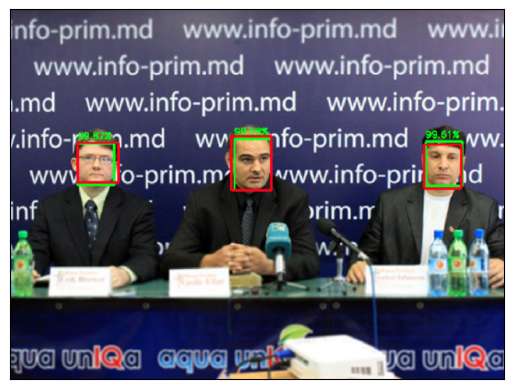

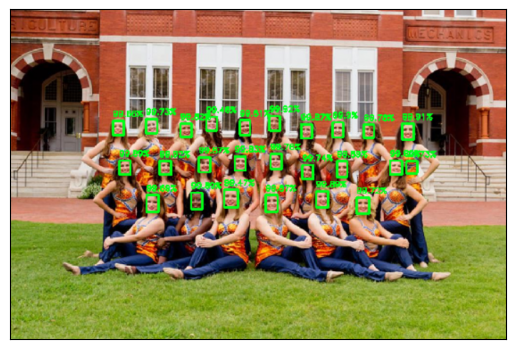

In [ ]:
# Definimos un par de imágenes de prueba
annot1 = config['valid']['valid_annot_folder'] + "9_Press_Conference_Press_Conference_9_74.xml"
annot2 = config['valid']['valid_annot_folder'] + "0_Parade_marchingband_1_149.xml"

# Detectamos caras en las imágenes de prueba
_ = _detect_one(
    model2,
    annot1,
    config['valid']['valid_image_folder'],
    is_annot = True,
    show_ground_truth = True)

_ = _detect_one(
    model2,
    annot2,
    config['valid']['valid_image_folder'],
    is_annot = True,
    show_ground_truth = False)

Lo que hemos observado es que consigue detectar caras muy bien cuando están bien separadas, e incluso las caras pequeñas o de perfil consigue detectarlas. Cuando hay muchas caras juntas y superpuestas (por ejemplo un grupo de personas en una foto tomada de lejos) a veces no detecta correctamente todas las caras. Sin embargo, en muchas fotos consigue detectar la mayoría con gran precisión.

**En verde mostramos la caja predicha por la red y en rojo el valor real de *ground truth*.**

Como solo tratamos con imágenes, **no hemos realizado ninguna prueba de detección en vídeo**. Para realizarla, habría que añadir a la carpeta de Drive `proyectovc` un vídeo llamado, por ejemplo, `test.mp4`. Una vez se tiene el archivo, se ejecutaría el siguiente código para obtener la detección de rostros en el vídeo:

`_detect_video(model3, DIR + "test.mp4", DIR + "test_out.mp4")`

Lo que hacemos es leer el vídeo con *OpenCV* para obtener las imágenes frame a frame, aplicarles nuestro detector y después volver a construir el vídeo con los mismos FPS.

# **6. Conclusiones**

**Hemos conseguido adaptar la red YOLOv3 preentranada en COCO sin conocimiento
previo de los objetos de tipo *face* para detectar correctamente estos. La
precisión conseguida es bastante buena.** Esto no es de extrañar, pues en el propio paper de YOLOv3 los autores comentan que el desempeño de la red en la métrica $mAP@0.5$ los resultados de YOLOv3 son igual de buenos entre las mejores redes; aunque comentan que la métrica COCO hace énfasis en mejores *bounding boxes* a costa de importar menos la clasificación por lo que no es necesariamente una mejor métrica.

Podríamos haber hecho más pruebas de entrenamiento, por ejemplo cambiando
el optimizador a SGD ó RMSprop o congelando algunos otros bloques concretos
de la red. También comentamos que hemos entrenado los modelos con un número
correcto de épocas a nuestro parecer (pues, en algunas pruebas con más épocas,
el resultado seguía siendo el mismo).

En general, aunque el rendimiento de esta red es bueno, existen otras redes como
Faster R-CNN o RetinaNet que podrían proporcionar mejores resultados en esta
tarea de detección, sin embargo **la ventaja que proporciona YOLOv3 sale a relucir cuando hay que hacer detecciones en tiempo real o hacerlas más rápidas**. Para un problema real habría que considerar que si queremos detección en tiempo real, YOLOv3 es de las mejores opciones, mientras que si queremos mayor precisión sin importar demasiado el tiempo, se considerarían otras redes con mayor precisión.